In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pymongo import MongoClient

pd.set_option("display.max_rows", None)
%matplotlib inline
%config InlineBackend.figure_formats="retina"

In [4]:
db = MongoClient(host="127.0.0.1", port=27017)["dlsc"]
tf_edges = pd.DataFrame(
    db["TensorFlow_edges"].find({}, projection={"_id": 0, "name": 1, "dependency": 1})
).drop_duplicates()
tf_edges = tf_edges[pd.notna(tf_edges["dependency"])]
pt_edges = pd.DataFrame(
    db["PyTorch_edges"].find({}, projection={"_id": 0, "name": 1, "dependency": 1})
).drop_duplicates()
pt_edges = pt_edges[pd.notna(pt_edges["dependency"])]
tf_edges.to_csv("data/TensorFlow/TensorFlow_edges.csv", index=False, header=False)
pt_edges.to_csv("data/PyTorch/PyTorch_edges.csv", index=False, header=False)

In [5]:
downloads_data = pd.read_csv("data/downloads.csv")
downloads_data.head()

,project,num_downloads
0,setuptools,221704541
1,botocore,200631873
2,urllib3,188264093
3,boto3,182167641
4,s3transfer,166867306


In [6]:
downloads_data["num_downloads"].describe()

count    3.332530e+05
mean     3.825680e+04
std      1.379994e+06
min      1.000000e+00
25%      9.500000e+01
50%      2.140000e+02
75%      5.670000e+02
max      2.217045e+08
Name: num_downloads, dtype: float64

In [7]:
tf_edges = pd.read_csv(
    "data/TensorFlow/TensorFlow_edges.csv", names=["dependent", "dependency"]
)
pt_edges = pd.read_csv(
    "data/PyTorch/PyTorch_edges.csv", names=["dependent", "dependency"]
)
tf_edges["dependent"] = tf_edges["dependent"].str.lower()
tf_edges["dependency"] = tf_edges["dependency"].str.lower()
pt_edges["dependent"] = pt_edges["dependent"].str.lower()
pt_edges["dependency"] = pt_edges["dependency"].str.lower()
tf_edges.head()

,dependent,dependency
0,dlomix,tensorflow
1,artap,tensorflow
2,wikirec,tensorflow
3,hipomap,tensorflow
4,failuredetectorscu,tensorflow


In [8]:
len(tf_edges["dependency"].unique()), len(pt_edges["dependency"].unique())

(275, 427)

In [9]:
tf_nodes = pd.DataFrame({"name": list(tf_edges["dependent"].unique())})
tf_nodes["has_dependents"] = False
tf_nodes.loc[tf_nodes["name"].isin(tf_edges["dependency"]), "has_dependents"] = True
tf_nodes.loc[:, "num_downloads"] = tf_nodes["name"].map(
    downloads_data.set_index("project")["num_downloads"]
)
tf_nodes["num_downloads"].fillna(0, inplace=True)
tf_nodes["num_downloads"] = tf_nodes["num_downloads"].astype(int)
len(tf_nodes), len(tf_nodes[tf_nodes["has_dependents"]])

(2543, 272)

In [11]:
tf_nodes[tf_nodes["num_downloads"] >= 3826].to_csv(
    "data/tensorflow_most_downloaded.csv", index=False
)

In [12]:
pt_nodes = pd.DataFrame({"name": list(pt_edges["dependent"].unique())})
pt_nodes["has_dependents"] = False
pt_nodes.loc[pt_nodes["name"].isin(pt_edges["dependency"]), "has_dependents"] = True
pt_nodes.loc[:, "num_downloads"] = pt_nodes["name"].map(
    downloads_data.set_index("project")["num_downloads"]
)
pt_nodes["num_downloads"].fillna(0, inplace=True)
pt_nodes["num_downloads"] = pt_nodes["num_downloads"].astype(int)
len(pt_nodes), len(pt_nodes[pt_nodes["has_dependents"]])

(3254, 426)

In [13]:
pt_nodes[pt_nodes["num_downloads"] >= 3826].to_csv(
    "data/pytorch_most_downloaded.csv", index=False
)

In [14]:
tf_nodes.to_csv("data/TensorFlow/TensorFlow_nodes.csv", index=False)
pt_nodes.to_csv("data/PyTorch/PyTorch_nodes.csv", index=False)

In [4]:
def calculate_cohen(rater1, rater2, categories):
    df = pd.DataFrame({"rater1": rater1, "rater2": rater2})
    df = (
        df.groupby(["rater1", "rater2"])
        .size()
        .reset_index(name="count")
        .pivot_table(index="rater1", columns="rater2", values="count", fill_value=0)
    )
    df = df[categories]
    df = df.reindex(categories)

    total_items = df.values.sum()
    sum1 = df.sum(axis=1)
    sum2 = df.sum(axis=0)

    p_e = sum(sum1 * sum2) / total_items**2
    p_0 = sum([df.loc[s, s] for s in categories]) / total_items

    return (p_0 - p_e) / (1 - p_e)

In [5]:
ups = pd.read_excel("data/most_downloaded_packages.xlsx")
calculate_cohen(
    ups["A's code"],
    ups["B' code"],
    ups["final code"].unique(),
)

0.9532446616812326

In [6]:
mapper = {'NLP': 'Applications->NLP',
 'CV': 'Applications->CV',
 'Unclear': 'Unclear->Unclear',
 'Framework': 'Infrastructure->Framework',
 'Model': 'Infrastructure->Model',
 'MLOps Platform': 'Infrastructure->MLOps Platform',
 'Miscellaneous Tools': 'Miscellaneous Tools->Miscellaneous Tools',
 'Biology': 'Sciences->Biology',
 'Probablistics Methods': 'Probablistics Methods->Probablistics Methods',
 'Audio': 'Applications->Audio',
 'Data Processing': 'Infrastructure->Data Processing',
 'Monitoring': 'Infrastructure->Monitoring',
 'Social Aspects': 'Social Aspects->Social Aspects',
 'Time Series': 'Applications->Time Series',
 'Reinforcement Learning': 'Reinforcement Learning->Reinforcement Learning',
 'Distributed Training': 'Infrastructure->Distributed Training',
 'Medicine': 'Sciences->Medicine',
 'AutoML': 'Infrastructure->AutoML',
 'Physics': 'Sciences->Physics',
 'IR': 'Applications->IR',
 'Economy': 'Sciences->Economy',
 'Optimization': 'Infrastructure->Optimization',
 'Mathematics': 'Sciences->Mathematics',
 'Training Simplication': 'Infrastructure->Training Simplication',
 'Deployment': 'Infrastructure->Deployment',
 'Other Disciplines': 'Sciences->Other Disciplines',
 'Graph': 'Applications->Graph',
 'Model Compression': 'Infrastructure->Model Compression',
 'Quantum Computing': 'Sciences->Quantum Computing',
 'Other Applications': 'Applications->Other Applications',
 'Evaluation': 'Infrastructure->Evaluation',
 'Security': 'Applications->Security',
 'Tabular Data': 'Applications->Tabular Data',
 'Education': 'Education->Education',
 'Model Conversion': 'Infrastructure->Model Conversion'}
mapper = {v: k for k, v in mapper.items()}

In [7]:
def compose_data():
    types = [
        "Applications->NLP",
        "Applications->CV",
        "Infrastructure->Framework",
        "Infrastructure->Model",
        "Infrastructure->MLOps Platform",
        "Sciences->Biology",
        "Miscellaneous Tools->Miscellaneous Tools",
        "Probablistics Methods->Probablistics Methods",
        "Infrastructure->Monitoring",
        "Social Aspects->Social Aspects",
        "Applications->Audio",
        "Infrastructure->Data Processing",
        "Applications->Time Series",
        "Reinforcement Learning->Reinforcement Learning",
        "Infrastructure->Distributed Training",
        "Infrastructure->AutoML",
        "Sciences->Medicine",
        "Applications->IR",
        "Sciences->Physics",
        "Sciences->Economy",
        "Applications->Other Applications",
        "Infrastructure->Optimization",
        "Infrastructure->Model Compression",
        "Sciences->Mathematics",
        "Infrastructure->Training Simplication",
        "Infrastructure->Deployment",
        "Sciences->Other Disciplines",
        "Applications->Graph",
        "Infrastructure->Evaluation",
        "Sciences->Quantum Computing",
        "Applications->Tabular Data",
        "Applications->Security",
        "Education->Education",
        "Infrastructure->Model Conversion",
    ]
    data = pd.read_excel("data/most_downloaded_packages.xlsx")
    # data = data[data["final code"] != ""]
    tf_ups = (
        data[data["TensorFlow"]]
        .groupby("final code")["name"]
        .count()
        .reindex(types)
        .fillna(0)
        .astype(int)
    )
    tf_ups = tf_ups / tf_ups.sum() * 100

    pt_ups = (
        data[data["PyTorch"]]
        .groupby("final code")["name"]
        .count()
        .reindex(types)
        .fillna(0)
        .astype(int)
    )
    pt_ups = pt_ups / pt_ups.sum() * 100

    res = pd.DataFrame(
        {
            "TensorFlow SC": tf_ups,
            "PyTorch SC": pt_ups
        }
    )
    res.rename(index=mapper, inplace=True)

    return res


comp_data = compose_data()
comp_data

,TensorFlow SC,PyTorch SC
final code,,
NLP,17.412935,20.242915
CV,7.462687,21.457490
Framework,5.472637,4.858300
Model,4.477612,4.048583
MLOps Platform,8.457711,3.643725
Biology,4.477612,2.834008
Miscellaneous Tools,2.985075,4.858300
Probablistics Methods,1.990050,3.643725
Monitoring,3.980100,1.619433


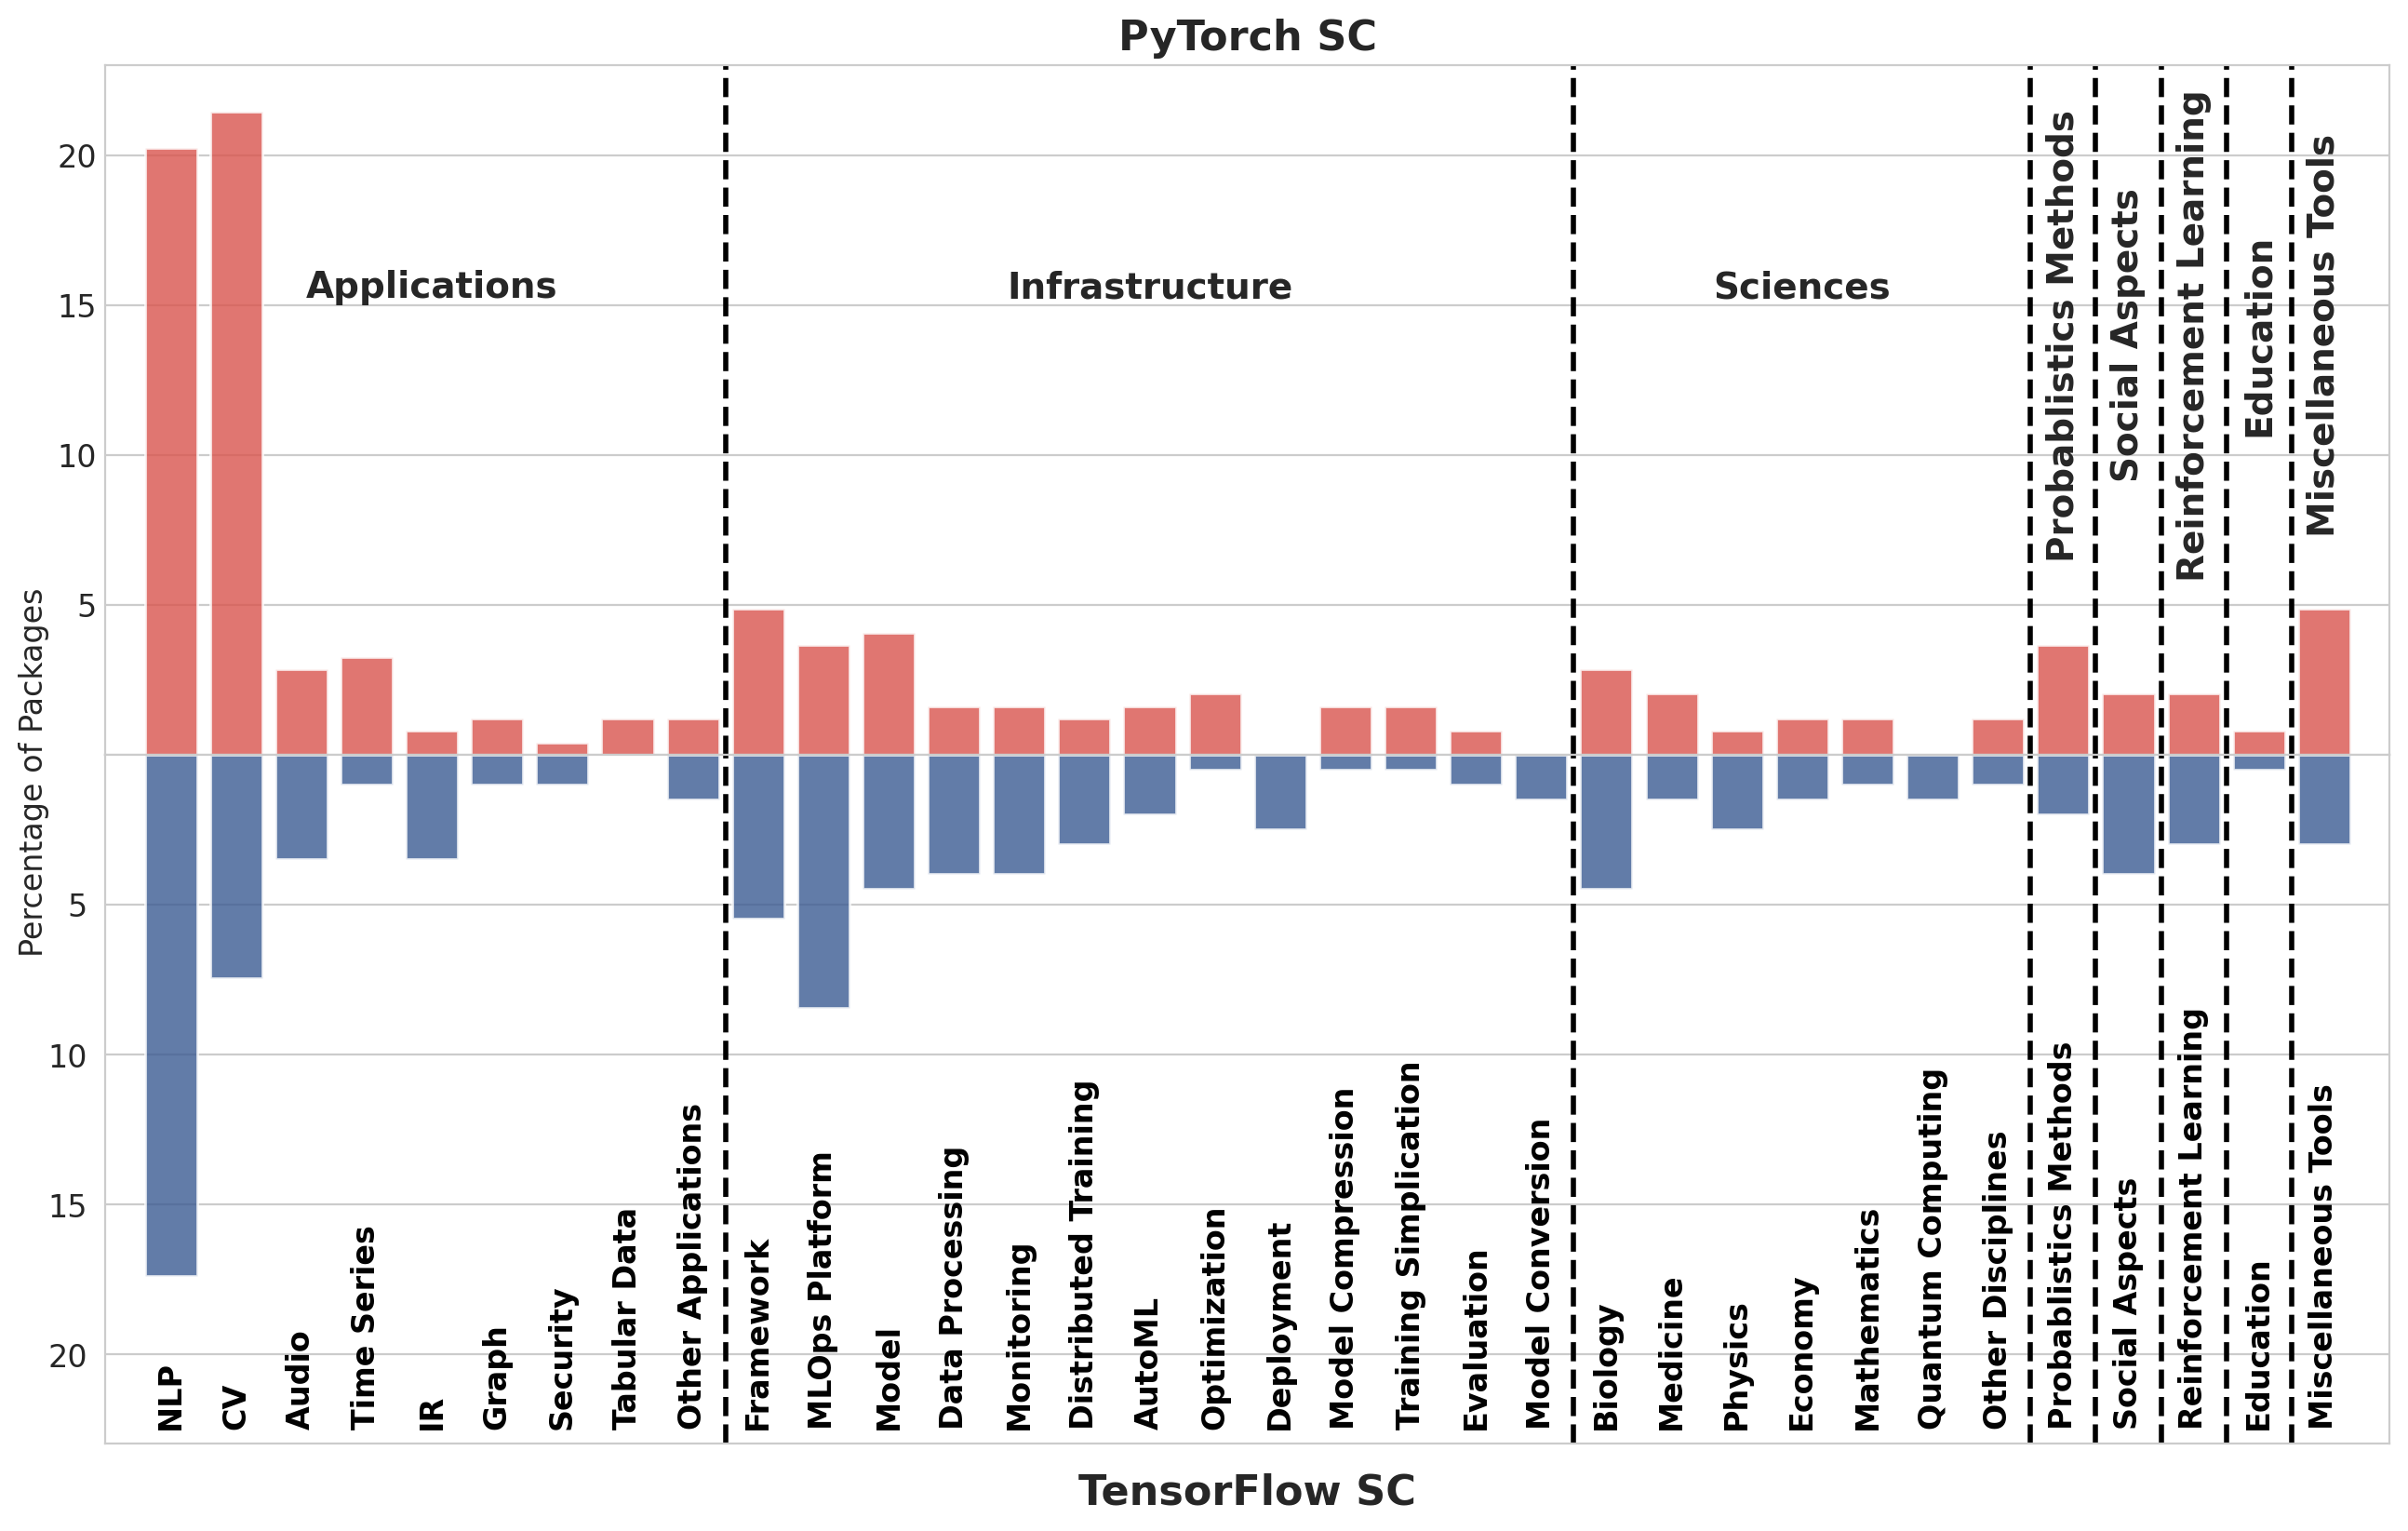

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_formats="retina"

def plot_package_domain_dist():
    types = [
        "NLP",
        "CV",
        "Audio",
        "Time Series",
        "IR",
        "Graph",
        "Security",
        "Tabular Data",
        "Other Applications",
        "Framework",
        "MLOps Platform",
        "Model",
        "Data Processing",
        "Monitoring",
        "Distributed Training",
        "AutoML",
        "Optimization",
        "Deployment",
        "Model Compression",
        "Training Simplication",
        "Evaluation",
        "Model Conversion",
        "Biology",
        "Medicine",
        "Physics",
        "Economy",
        "Mathematics",
        "Quantum Computing",
        "Other Disciplines",
        "Probablistics Methods",
        "Social Aspects",
        "Reinforcement Learning",
        "Education",
        "Miscellaneous Tools"
    ]

    with sns.axes_style("whitegrid"):
        fig, axes = plt.subplots(figsize=(13, 8), nrows=2, sharex=True)
        fig.tight_layout()
        width = 0.8

        for i, f in enumerate(["PyTorch", "TensorFlow"]):
            data0 = comp_data[f"{f} SC"].reindex(types)
            if i == 0:
                axes[i].bar(
                    np.arange(len(types)),
                    data0.values,
                    color=sns.xkcd_rgb["pale red"],
                    alpha=0.8,
                )
            else:
                axes[i].bar(
                    np.arange(len(types)),
                    data0.values,
                    color=sns.xkcd_rgb["denim blue"],
                    alpha=0.8,
                )

            axes[i].set_xlim(-1, len(types))
            axes[i].set_ylim(0, 23)
            axes[i].tick_params(axis="y", labelsize=12)

            axes[i].set_yticks([5, 10, 15, 20])
            axes[i].set_yticklabels([5, 10, 15, 20])
        
        axes[0].set_title("PyTorch SC", fontsize=16, fontweight="heavy")
        axes[1].set_xlabel("TensorFlow SC", fontsize=16, fontweight="heavy")
        
        axes[1].invert_yaxis()
        axes[0].xaxis.grid(False)
        axes[1].xaxis.grid(False)

        axes[0].tick_params(axis="y", color="white", length=0)  # tick color
        axes[0].get_xaxis().set_ticklabels([])

        for i, label in enumerate(types):
            plt.text(
                x=i,
                y=22.5,
                s=label,
                color="black",
                horizontalalignment="center",
                verticalalignment="bottom",
                zorder=12,
                fontsize=12,
                fontweight="semibold",
                rotation=90,
            )

        axes[0].axvline(x=8.5, color="k", linestyle="--", linewidth=2)
        axes[1].axvline(x=8.5, color="k", linestyle="--", linewidth=2)
        axes[0].axvline(x=21.5, color="k", linestyle="--", linewidth=2)
        axes[1].axvline(x=21.5, color="k", linestyle="--", linewidth=2)
        axes[0].axvline(x=28.5, color="k", linestyle="--", linewidth=2)
        axes[1].axvline(x=28.5, color="k", linestyle="--", linewidth=2)
        axes[0].axvline(x=29.5, color="k", linestyle="--", linewidth=2)
        axes[1].axvline(x=29.5, color="k", linestyle="--", linewidth=2)
        axes[0].axvline(x=30.5, color="k", linestyle="--", linewidth=2)
        axes[1].axvline(x=30.5, color="k", linestyle="--", linewidth=2)
        axes[0].axvline(x=31.5, color="k", linestyle="--", linewidth=2)
        axes[1].axvline(x=31.5, color="k", linestyle="--", linewidth=2)
        axes[0].axvline(x=32.5, color="k", linestyle="--", linewidth=2)
        axes[1].axvline(x=32.5, color="k", linestyle="--", linewidth=2)

        axes[0].text(
            4,
            15,
            "Applications",
            ha="center",
            va="bottom",
            fontsize=14,
            fontweight="heavy",
        )
        axes[0].text(
            15,
            15,
            "Infrastructure",
            ha="center",
            va="bottom",
            fontsize=14,
            fontweight="heavy",
        )
        axes[0].text(
            25,
            15,
            "Sciences",
            ha="center",
            va="bottom",
            fontsize=14,
            fontweight="heavy",
        )
        axes[0].text(
            29,
            14,
            "Probablistics Methods",
            ha="center",
            va="center",
            fontsize=14,
            fontweight="heavy",
            rotation=90,
        )
        axes[0].text(
            30,
            14,
            "Social Aspects",
            ha="center",
            va="center",
            fontsize=14,
            fontweight="heavy",
            rotation=90,
        )
        axes[0].text(
            31,
            14,
            "Reinforcement Learning",
            ha="center",
            va="center",
            fontsize=14,
            fontweight="heavy",
            rotation=90,
        )
        axes[0].text(
            32,
            14,
            "Education",
            ha="center",
            va="center",
            fontsize=14,
            fontweight="heavy",
            rotation=90,
        )
        axes[0].text(
            33,
            14,
            "Miscellaneous Tools",
            ha="center",
            va="center",
            fontsize=14,
            fontweight="heavy",
            rotation=90,
        )
        fig.supylabel("Percentage of Packages", x=0)
        plt.subplots_adjust(hspace=0)
        plt.savefig("figures/most_downloaded_package_domains.pdf", bbox_inches="tight")


plot_package_domain_dist()

In [2]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize

df = pd.read_excel("data/most_downloaded_packages.xlsx")
df = df[df["final code"] != "Unclear->Unclear"]
df.loc[:, "category"] = df.loc[:, "final code"].apply(lambda x: x.split("-")[0])
tf_df = df[df["TensorFlow"]]
pt_df = df[df["PyTorch"]]

for cat in ["Applications", "Infrastructure", "Sciences", "Probablistics Methods", "Social Aspects", "Reinforcement Learning", "Education", "Miscellaneous Tools"]:
    print(cat)
    count = np.array([len(tf_df[tf_df["category"] == cat]), len(pt_df[pt_df["category"] == cat])])
    nobs = np.array([len(tf_df), len(pt_df)])
    tf_ratio = len(tf_df[tf_df["category"] == cat]) / len(tf_df)
    pt_ratio = len(pt_df[pt_df["category"] == cat]) / len(pt_df)
    if tf_ratio < pt_ratio:
        alternative = "smaller"
    else:
        alternative = "larger"
    stat, pval = proportions_ztest(count, nobs, alternative=alternative)
    print(f'{tf_ratio}, {pt_ratio}, p-value: {pval}'.format(pval))

Applications
0.36318407960199006, 0.5263157894736842, p-value: 0.0002805099048591157
Infrastructure
0.3781094527363184, 0.24696356275303644, p-value: 0.0013659412650204165
Sciences
0.13432835820895522, 0.0931174089068826, p-value: 0.08413966936665279
Probablistics Methods
0.01990049751243781, 0.03643724696356275, p-value: 0.14984533985873838
Social Aspects
0.03980099502487562, 0.020242914979757085, p-value: 0.10999048510514581
Reinforcement Learning
0.029850746268656716, 0.020242914979757085, p-value: 0.2567033073461722
Education
0.004975124378109453, 0.008097165991902834, p-value: 0.34348144340190256
Miscellaneous Tools
0.029850746268656716, 0.048582995951417005, p-value: 0.157649605999385


In [4]:
df[df["TensorFlow"] & df["PyTorch"]]["category"].value_counts()

Applications              18
Infrastructure            12
Miscellaneous Tools        3
Social Aspects             2
Reinforcement Learning     2
Probablistics Methods      1
Sciences                   1
Name: category, dtype: int64